# Probabilistic Graphical Models: HW2
Nicolas ATIENZA, Thomas CHAPALAIN -- Master MVA

This notebook only aims to answer the questions of the lab and represent the results of the implemented algorithms. All the source code used are present in the `./Code/` folder present in the archive that has been handed out

## Noisy Ising

Let's consider a simple Ising model:

\begin{equation*} p(x) = \frac{1}{Z} \exp\left\{ \sum\limits_{i=1}^n \alpha x_i + \beta \sum\limits_{i,j\in E} \delta(x_i=x_j) \right\} \end{equation*}

Where $x\in \{0,1\}^n$ and the observations are distributed according a Gaussian:

\begin{equation*}  y_i|x_i \sim \mathcal{N}(\mu_{x_i}, 1)  \end{equation*}

![](Data/spiral.png)

### 1- Loopy belief propagation

In this question, we plan to implement a loopy belief propagation algorithm in order to denoise an image. The loopy belief propagation algorithm is the adaptation of the belief propagation algorithm that is defined on trees. To adapt this algorithm we define the following potential function:

\begin{equation*} \psi_i(x_i) = \delta (x_i=y_i) \end{equation*}

Then we implement the belief algorithm as we know it hoping that eventually the message will converge. The Loopy belief algorithm provides therefore an approximate solution.


To implement the Loopy belief propagation, we follow the following scheme:

1. Initialise all messages:
\begin{equation*} \forall j \in [0,2], \forall i \in N(j), ~ \mu_{j\to i}(x_j) = 1 \end{equation*}
2. for all node j in graph, update its message:
\begin{equation*} \forall i \in N(j), ~ mu_{j\to i}(x_j) = \sum\limits_{l=0}^{1} \psi_i(l)\psi_{i,j}(x_j, l) \prod\limits_{k \in N(j)/i}\mu_{k\to j}(x_j) \end{equation*}

We can repeat this scheme a fixed number of times or until convergence of messages to a fixed point. The estimation of the image is realised by maximising the marginal distribution:

\begin{equation*} p(x_i) \propto \psi_i(x_i) \prod\limits_{k\in N(i)} \mu_{k\to i}(x_i) \end{equation*}
\begin{equation*} \hat{x_i} = \max\limits_{x_i} \psi_i(x_i) \prod\limits_{k\in N(i)} \mu_{k\to i}(x_i) \end{equation*}

In [2]:
from Code.LBP import LBP

In [3]:
param = {}
param['alpha'] = .1
param['beta']  = .5
param['nu']    = [.2,.8]
a=LBP(dataPath='./Data/spiral.png', parameters=param, n_iter=3)

100%|██████████| 280000/280000 [00:52<00:00, 5324.85it/s]


Accuracy : 0.9768535714285714


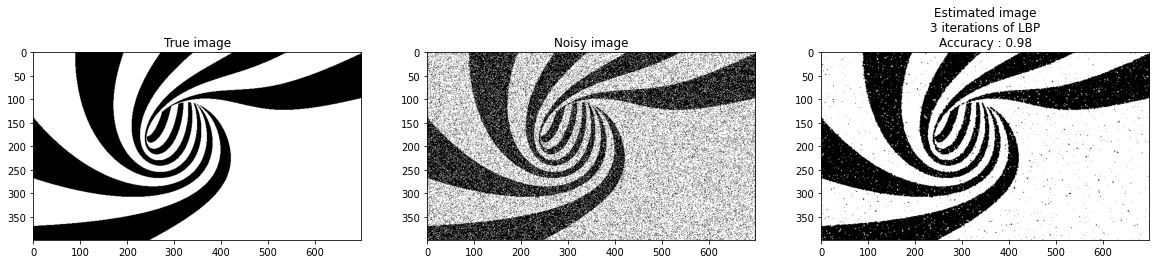

In [4]:
a.show_results(save_path='./Fig')

### 2- MCMC Methods

Instead of performing a message passing algorithm, we may use a Markov Chain Monte Carlo algorithm to sample from the same conditionnal distribution $x|y$. Sampling according to this law is not an easy task as it would require to compute the intractable normalisation constant of the Ising model. Instead, we can use a Gibbs sampling that enables to estimate a sampling of this law by iteratively sampling according to $x_i|x_{-i}$. 

\begin{align*} 
\forall i \in [0,n], ~ p(x_i, x_{-i}, y_i) &= p(y_i)p(x_i, x_{-i}) \\
p(x_i, x_{-i}, y_i) &= \frac{1}{2} \exp\left\{ -\frac{1}{2} (y_i-x_i)^2 \right\} \frac{1}{Z} \prod\limits_{l=1}^{n}e^{\alpha x_l} \prod\limits_{l,m \in E} e^{\beta \delta(x_l=x_m)}
\end{align*}

By dropping all the terms that are not related to $x_i$ in this expression, we get the distribution $x_i|x_{-i},y_i$:

\begin{equation*} p(x_i | x_{-i},y_i) \propto \exp \left\{- \frac{1}{2} (y_i-\mu_{x_i})^2 \right\} e^{\alpha x_i} \prod\limits_{i,j \in E} e^{\beta \delta(x_i=x_j)} \end{equation*}

Therefore, we see that it is a quite easy task to sample from $x_i|x_{-i}$ as all quantity involved are fixed and the normalisation constant requires only a sum of two terms. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Code.utils import load_binary_image
from Code.Gibbs import gibbs_sampler, blur_img

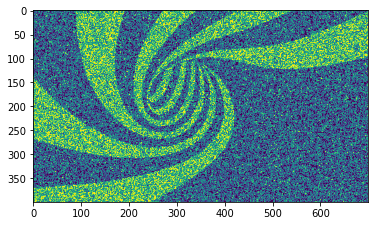

In [8]:
alpha  = .1
beta   = .5
n_iter =  50
Y      = blur_img(load_binary_image('./Data/spiral.png'), 0, 1, 1).astype('int')
X      = np.ones(Y.shape, dtype='int')
plt.imshow(Y)
plt.show()

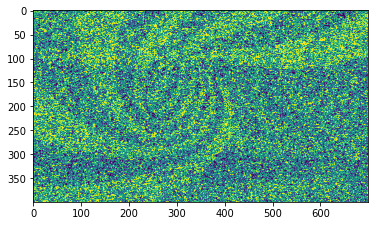

In [7]:
X_est  = gibbs_sampler(n_iter, alpha, beta, Y, X, 0, 1)
plt.imshow(X_est)
plt.show()

### 3- EM Algorithm

Now we propose to infer the values of $\mu_0$ and $\mu_1$. To do, we may use an EM algorithm. The update rule of the EM requires to maximise the expected value of the complete likelihood according to $x|y$.

The complete log likelihood is easily derived as:

\begin{align*}
    \log p(x,y) &= \log p(y|x) + \log p(x) \\
    \log p(x,y) &= \sum\limits_{i=1}^n \alpha x_i + \beta \sum\limits_{i,j \in E} \delta(x_i=x_j) - \frac{1}{2} \sum\limits_{i=1}^n (y_i-\mu_{x_i})^2 + cst\\
    \log p(x,y) &= L_{x,y}(\mu)
\end{align*}

The expected value of this quantity according to $x|y$ is derived as:

\begin{equation*} \mathbb{E}_{x|y}(L_{x,y}(\mu)) = -\frac{1}{2} \sum\limits_{i=1}^n \sum\limits_{k=0}^1 p(x_i=k|y)(y_i-\mu_k)^2 + cst \end{equation*}

This function being quadractic w.r.t the parameters, it reaches a global maximum when its gradient is null.

\begin{equation*} \frac{\partial \mathbb{E}_{x|y}(L_{x,y}(\mu)) }{\partial \mu_k} = \sum\limits_{i=1}^n p(x_i=k|y)(y_i-\mu_k) \end{equation*}

Therefore, the update rule of the EM algorithm is: 

\begin{equation*} \frac{\partial \mathbb{E}_{x|y}(L_{x,y}(\mu)) }{\partial \mu_k} =0 \iff \hat{\mu}_k = \frac{ \sum\limits_{i=1}^n y_i p(x_i=k|y)}{\sum\limits_{i=1}^n y_i}\end{equation*}

The probability $p(x|y)$ being not intractable, we propose to implement a Gibbs SAEM algorithm to estimate the likelihood and then infer the parameters. The Question 2 can be used to sample from the law $x|y$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Code.utils import load_binary_image
from Code.SAEM import SAEM, blur_img

In [4]:
alpha  = .1
beta   = .5
n_iter =  50
Y      = blur_img(load_binary_image('./Data/spiral.png'), 0, 1, .2).astype('int')
X      = np.ones(Y.shape, dtype='int')
X_est, u0, u1  = SAEM(.5,.5, Y, 10, 10, alpha, beta)
print(u0, u1)

0.3511379213898465 0.3504749688045347


### 4- Inference on other parameters

If we consider that $\alpha$ and $\beta$ are also unknown, then we cannont infer them thanks an EM algorithm. Indeed, Z depends on this parameter and is intractable.